In [8]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [9]:
data_dir=r"/mnt/c/Users/Asus/Mini_Project/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [10]:
from tensorflow.image import resize
#Load and preprocess audio data
def load_and_preprocess_data(data_dir,classes,target_shape=(150,150)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        class_dir = os.path.join(data_dir,class_name)
        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir,filename)
                audio_data,sample_rate = librosa.load(file_path,sr=None)
                #Performing Preprocessing
                #define the duration of each chunk and overlap
                chunk_duration = 4
                overlap_duration = 2
                
                #Convert duration to sample
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate
                
                #Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1
                
                #iterate over each chunks
                for i in range(num_chunks):
                    #Calculate start and end indices of the chunk
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    #Extract the chunk audio
                    chunk = audio_data[start:end]
                    #Melspectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                    #Resize matrix based on provided target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                    #Append data to list
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    #Return
    return np.array(data),np.array(labels)
    

In [11]:
data,labels = load_and_preprocess_data(data_dir,classes)

Processing-- blues


I0000 00:00:1733290904.411191     953 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [12]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

In [14]:
model = tf.keras.models.Sequential()

In [15]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

/mnt/c/Users/Asus/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [17]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [18]:
model.add(Dropout(0.3))

In [19]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [20]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [21]:
model.add(Dropout(0.3))

In [22]:
model.add(Flatten())

In [23]:
model.add(Dense(units=1200,activation='relu'))

In [24]:
model.add(Dropout(0.45))

In [25]:
#Output layer
model.add(Dense(units=len(classes),activation='softmax'))

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30


I0000 00:00:1733291296.941428    1192 service.cc:148] XLA service 0x7faebc0272f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733291296.942960    1192 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-12-04 05:48:17.377883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733291298.097654    1192 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733291314.362619    1192 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1949 - loss: 2.1494

2024-12-04 05:49:07.715862: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_176', 172 bytes spill stores, 172 bytes spill loads

2024-12-04 05:49:07.719918: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_176', 532 bytes spill stores, 532 bytes spill loads

2024-12-04 05:49:15.332813: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_176', 116 bytes spill stores, 116 bytes spill loads

2024-12-04 05:49:15.385923: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_176', 512 bytes spill stores, 432 bytes spill loads



375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 118ms/step - accuracy: 0.1951 - loss: 2.1489 - val_accuracy: 0.4237 - val_loss: 1.5931
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.4463 - loss: 1.5411 - val_accuracy: 0.5626 - val_loss: 1.2334
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.5664 - loss: 1.2207 - val_accuracy: 0.6127 - val_loss: 1.0937
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.6566 - loss: 0.9972 - val_accuracy: 0.7112 - val_loss: 0.8542
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.7058 - loss: 0.8703 - val_accuracy: 0.7563 - val_loss: 0.7380
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.7521 - loss: 0.7276 - val_accuracy: 0.7549 - val_loss: 0.7175
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.8005 - loss: 0.5876 - val_accuracy: 0.7806 - val_loss: 0.6474
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8329 - loss: 0.4976 - val_accura

In [29]:
model.save("Trained_model.keras")

In [30]:
training_history.history

{'accuracy': [0.26419031620025635,
  0.4849749505519867,
  0.5944908261299133,
  0.6682804822921753,
  0.7191151976585388,
  0.7582637667655945,
  0.8019198775291443,
  0.8342236876487732,
  0.8500000238418579,
  0.8770450949668884,
  0.8975793123245239,
  0.9101001620292664,
  0.9237896203994751,
  0.9281302094459534,
  0.9413188695907593,
  0.9447412490844727,
  0.9534223675727844,
  0.9550918340682983,
  0.9616861343383789,
  0.9647746086120605,
  0.9691151976585388,
  0.9695325493812561,
  0.9791318774223328,
  0.9748747944831848,
  0.9753756523132324,
  0.9783806204795837,
  0.976961612701416,
  0.9772955179214478,
  0.9789649248123169,
  0.9868113398551941],
 'loss': [1.9785200357437134,
  1.440102458000183,
  1.1466387510299683,
  0.9608591794967651,
  0.8386232256889343,
  0.711923360824585,
  0.5842565298080444,
  0.49351373314857483,
  0.44591984152793884,
  0.35885852575302124,
  0.30138248205184937,
  0.26791226863861084,
  0.22921602427959442,
  0.21581104397773743,
  0.17

In [31]:
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)
    

In [32]:
X_train


array([[[[3.2394952e+02],
         [1.3065462e+02],
         [6.7034545e+00],
         ...,
         [4.3478961e+00],
         [3.3688255e+01],
         [7.3319199e+01]],

        [[6.4282874e+02],
         [3.4481317e+02],
         [2.4032497e+01],
         ...,
         [5.4154785e+01],
         [1.8837808e+02],
         [2.7204626e+02]],

        [[4.7228046e+02],
         [2.4064510e+02],
         [2.2244192e+01],
         ...,
         [1.0659833e+02],
         [3.5626904e+02],
         [2.6705249e+02]],

        ...,

        [[2.5943061e-03],
         [5.4452819e-04],
         [3.3627573e-05],
         ...,
         [2.4564300e-05],
         [3.0641881e-05],
         [6.9904629e-05]],

        [[2.5715521e-03],
         [5.2518927e-04],
         [2.9510520e-06],
         ...,
         [2.1084190e-06],
         [6.1495894e-06],
         [5.3449046e-05]],

        [[2.5453654e-03],
         [5.1769981e-04],
         [7.9050622e-08],
         ...,
         [7.0884809e-08],
        

In [33]:
model = tf.keras.models.load_model("Trained_model.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,547,376 (82.20 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,364,918 (54.80 MB)

In [34]:
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)
    

In [35]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:

train_loss,train_accuracy = model.evaluate(X_train,Y_train)

371/375 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9954 - loss: 0.0131

2024-12-04 06:09:48.919869: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_176', 108 bytes spill stores, 108 bytes spill loads



375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9954 - loss: 0.0130


In [38]:
train_loss,train_accuracy

(0.012209664098918438, 0.9959098696708679)

In [39]:
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9206 - loss: 0.3069


In [40]:
val_loss,val_accuracy


(0.3212624788284302, 0.9171953201293945)

In [41]:
training_history_data['val_loss']

[1.593065857887268,
 1.2334346771240234,
 1.0937410593032837,
 0.8541682958602905,
 0.7379757165908813,
 0.7174941897392273,
 0.6474014520645142,
 0.5307714343070984,
 0.517778217792511,
 0.478776752948761,
 0.44782161712646484,
 0.4275108277797699,
 0.4475013315677643,
 0.4035002589225769,
 0.3696523904800415,
 0.36703968048095703,
 0.39395830035209656,
 0.3999616205692291,
 0.33273521065711975,
 0.40171584486961365,
 0.45593807101249695,
 0.327300488948822,
 0.40439775586128235,
 0.42021045088768005,
 0.36006659269332886,
 0.3503577411174774,
 0.35397204756736755,
 0.4376308023929596,
 0.38571566343307495,
 0.3212624788284302]

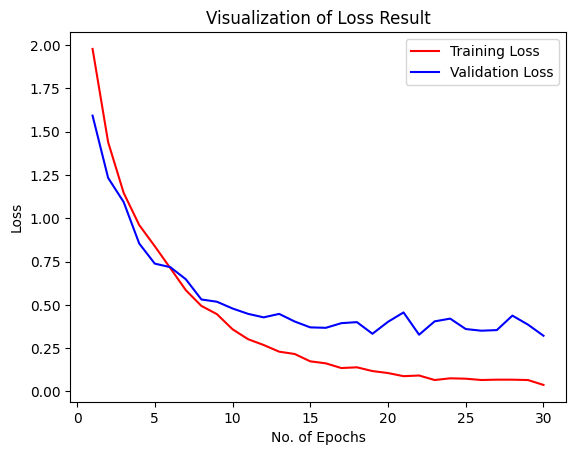

In [42]:
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

In [43]:
y_pred = model.predict(X_test)
y_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


array([[3.4386946e-03, 1.1257434e-05, 1.1147328e-04, ..., 9.5565003e-01,
        3.6035920e-04, 2.4024921e-03],
       [7.3211328e-14, 2.4828604e-17, 4.8279629e-15, ..., 4.6739870e-20,
        1.6873117e-14, 1.0391873e-07],
       [5.6335264e-13, 3.8937094e-13, 2.2047169e-12, ..., 1.2250010e-11,
        2.6840165e-14, 2.2736115e-06],
       ...,
       [5.6353074e-01, 8.2395417e-11, 3.0501467e-01, ..., 2.7580391e-10,
        8.8336878e-05, 1.3132730e-01],
       [1.2709952e-03, 9.9187863e-01, 7.6788150e-05, ..., 2.9201011e-04,
        5.6476315e-04, 9.8707026e-04],
       [2.6185971e-05, 2.0779417e-08, 3.8312606e-05, ..., 3.9364309e-03,
        5.4939844e-02, 5.8050926e-05]], dtype=float32)

In [44]:
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

array([7, 6, 6, ..., 0, 1, 4])

In [45]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([7, 6, 6, ..., 0, 1, 4])

In [46]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

              precision    recall  f1-score   support

       blues       0.92      0.92      0.92       302
   classical       0.94      0.97      0.95       298
     country       0.87      0.79      0.83       317
       disco       0.91      0.95      0.93       312
      hiphop       0.95      0.96      0.95       277
        jazz       0.91      0.94      0.93       311
       metal       0.98      0.97      0.98       302
         pop       0.97      0.90      0.93       289
      reggae       0.89      0.95      0.92       296
        rock       0.85      0.83      0.84       291

    accuracy                           0.92      2995
   macro avg       0.92      0.92      0.92      2995
weighted avg       0.92      0.92      0.92      2995



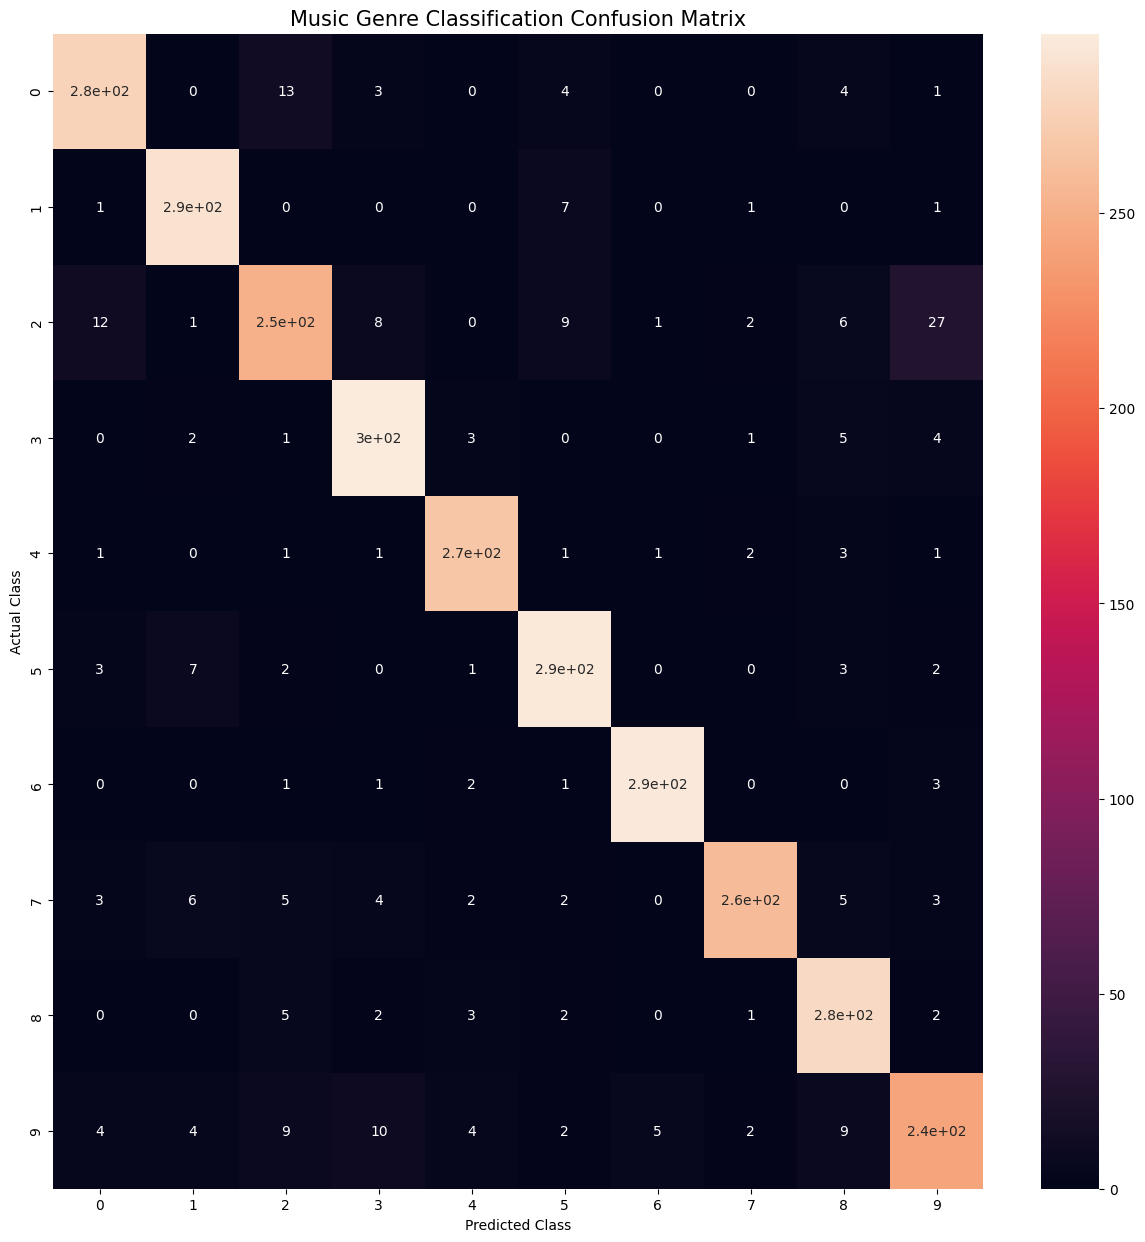

In [47]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()